# Final Assignment - Companion Jupyter Notebook

Code written by Jamie Chiu and Meet Patel.  
Final paper written by: Greg Guggenmos (introduction, conclusion, references), Nicholas Toth (abstract, introduction, conclusion), Meet Patel (abstract, methods, results, conclusion), and Jamie Chiu (methods, results, conclusion).

<br>

***

<br>

This notebook contains all code necessary to recreate our analyses and plots. 

Table of contents:  
* Description of variables and models  
* Loading + preprocessing data
* Task 1: New Child Prediction  
* Task 2: Subjective Health Rating Prediction  

<br>

***
 
## Description of Variables and Models

Our goal is to create baseline models using socio-demographic background data, compared against dummy and at-chance models. 

The variables we use are:
* age  
* gender 
* educational attainment  
* income level  
* race / ethnicity    

Outcome variables to predict:   
1. Whether or not an individual had a new child during 2021-23 (binary outcome)  
2. The individual's self-reported health (multiclass, 1-5)  

Models compared are:
* Logistic regression   
* Neural network  
* Gaussian Naive Bayes  
* Support Vector Classifier  
* Random Forest  
* k-Nearest Neighbour  
    
The random models are:
* True Random Dummy - where each class label is chosen at equal probability 
* Stratified Random Dummy - randomly sampling one-hot vectors from a multinomial distribution parameterized by the empirical class prior probabilities  
* Weighted Random - where each class label is chosen with probability proportional to its frequency among labels in the training data  

We also include the model that was submitted to PreFer as a comparison point for the new child prediction task.  

<br>

***


## Loading and Preprocessing Data


In [1]:
import pandas as pd
import numpy as np
import sklearn
import random
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
########################################
# GET DEMOGRAPHIC VARIABLES
########################################

# load in codebook to examine what background variables they have
codebook = pd.read_csv('codebook/PreFer_codebook_summary.csv') 
# print(codebook.columns) # see what background variables are in the dataset
background_vars = codebook[codebook['survey'] == 'Background Variables']['var_label_across_waves']
# print(background_vars) # uncomment to see all variables

# find variable names using labels
vars_list = [
    'Level of education in CBS (Statistics Netherlands) categories',
    'Year of birth [imputed by PreFer organisers]',
    'Gender [imputed by PreFer organisers]',
    'Origin [imputed by PreFer organisers]',
    'Gross household income in Euros'
]
filtered_rows = codebook[codebook['var_label_across_waves'].isin(vars_list)]
# show variable labels + names
print("Variable labels and variable names that may be of interest:")
display(filtered_rows[['var_label_across_waves', 'var_names']])

# list out variables we want in our baseline models
background_var_names = [
    'nomem_encr', # ID 
    'birthyear_imp', # imputed year of birth
    'gender_imp', # imputed gender
    'migration_background_imp', # origin
    'oplcat', # education
    'brutohh_f', # gross household income
]

# load background info dataset and locate the variables we want
background_data = pd.read_csv('training_data/PreFer_train_background_data.csv', low_memory=False) 
background_data_vars = background_data[background_var_names]
print("Background variables of interest (head):")
display(background_data_vars.head()) # lots of duplicates and multiple entries due to income over waves

Variable labels and variable names that may be of interest:


,var_label_across_waves,var_names
3276,Year of birth [imputed by PreFer organisers],birthyear_bg
3277,Gender [imputed by PreFer organisers],gender_bg
3278,Origin [imputed by PreFer organisers],migration_background_bg
3281,Gross household income in Euros,brutohh_f_2007; brutohh_f_2008; brutohh_f_2009...
3289,Level of education in CBS (Statistics Netherla...,oplcat_2007; oplcat_2008; oplcat_2009; oplcat_...
3314,Level of education in CBS (Statistics Netherla...,oplcat; oplcat; oplcat; oplcat; oplcat; oplcat...
3321,Gross household income in Euros,brutohh_f; brutohh_f; brutohh_f; brutohh_f; br...
3325,Year of birth [imputed by PreFer organisers],birthyear_imp; birthyear_imp; birthyear_imp; b...
3326,Gender [imputed by PreFer organisers],gender_imp; gender_imp; gender_imp; gender_imp...
3327,Origin [imputed by PreFer organisers],migration_background_imp; migration_background...


Background variables of interest (head):


,nomem_encr,birthyear_imp,gender_imp,migration_background_imp,oplcat,brutohh_f
0,700003,1965,2,0.0,3.0,NaN
1,700003,1965,2,0.0,3.0,NaN
2,700003,1965,2,0.0,3.0,NaN
3,700003,1965,2,0.0,3.0,NaN
4,700003,1965,2,0.0,3.0,NaN


In [3]:
########################################
# CLEAN UP DATA
########################################

# aggregate data so that each ID can be on one row only, instead of being duplicated for each wave
# first, aggregate for each ID the mean income and max education across waves
grouped_data = background_data_vars.groupby('nomem_encr').agg({'brutohh_f': 'mean', 'oplcat': 'max'})
grouped_data = grouped_data.reset_index() # ungroup

# impute NAs with median (this is if data is missing for all waves for this ID)
grouped_data['brutohh_f'] = grouped_data['brutohh_f'].fillna((grouped_data['brutohh_f'].median()))
grouped_data['oplcat'] = grouped_data['oplcat'].fillna((grouped_data['oplcat'].median()))
print("Check that income and education are now aggregated for each ID:")
display(grouped_data.head())

# add the income and education back with the rest of our background variables
merge_data = background_data[background_var_names[:-2]].drop_duplicates()
# fix NaNs on migration; for simplicity, let's recode to Dutch or not Dutch
# "c(`Dutch background` = 0, `First generation foreign, Western background` = 101, `First generation foreign, non-western background` = 102, `Second generation foreign, Western background` = 201, `Second generation foreign, non-western background` = 202, `Origin unknown or part of the information unknown (missing values)` = 999)",1
merge_data['migration_background_imp'] = np.where(merge_data['migration_background_imp'] > 0, 1, 0) # recode migration data
df = pd.merge(merge_data, grouped_data, on='nomem_encr')
print("Cleaned up background variables dataset:")
display(df)

print("Check that there are no more missing data:")
print(df.isna().sum()) # no NaNs




Check that income and education are now aggregated for each ID:


,nomem_encr,brutohh_f,oplcat
0,700003,2893.988671,3.0
1,700004,11177.777778,5.0
2,700008,7320.808037,4.0
3,700010,2165.512842,4.0
4,700016,3051.677046,3.0


Cleaned up background variables dataset:


,nomem_encr,birthyear_imp,gender_imp,migration_background_imp,brutohh_f,oplcat
0,700003,1965,2,0,2893.988671,3.0
1,700004,1980,2,0,11177.777778,5.0
2,700008,1991,2,0,7320.808037,4.0
3,700010,1987,2,0,2165.512842,4.0
4,700016,1984,1,1,3051.677046,3.0
...,...,...,...,...,...,...
12849,733177,1994,2,1,5680.000000,4.0
12850,733178,1962,1,0,3763.564356,4.0
12851,733179,1992,1,0,10434.437570,4.0
12852,733181,1958,1,0,4608.940516,5.0


Check that there are no more missing data:
nomem_encr                  0
birthyear_imp               0
gender_imp                  0
migration_background_imp    0
brutohh_f                   0
oplcat                      0
dtype: int64


In [4]:
########################################
# GET OUTCOME DATA
########################################

# load in main dataset - this takes a while, so keep this line of code in it's own cell
main_data = pd.read_csv('training_data/PreFer_train_data.csv', low_memory=False) 

In [5]:
## for new child prediction

# get IDs that have outcome data
have_outcome_child = main_data[main_data['outcome_available'] == 1]['nomem_encr']
child_df = df[df['nomem_encr'].isin(have_outcome_child)]

## for health ratings

# get IDs that have outcome data
have_outcome_health = main_data[main_data['ch20m004'].isna() == False]['nomem_encr']
health_df = df[df['nomem_encr'].isin(have_outcome_health)]

# check that there are no missing data
print("Check that there are no missing data in our new child and health df:")
print(child_df.isna().sum())
print(health_df.isna().sum())

Check that there are no missing data in our new child and health df:
nomem_encr                  0
birthyear_imp               0
gender_imp                  0
migration_background_imp    0
brutohh_f                   0
oplcat                      0
dtype: int64
nomem_encr                  0
birthyear_imp               0
gender_imp                  0
migration_background_imp    0
brutohh_f                   0
oplcat                      0
dtype: int64


<br>

***


## Prediction Task 1: New Child?

In [6]:

# get new child labels from PreFer outcomes dataset
outcome_data = pd.read_csv('training_data/PreFer_train_outcome.csv')

# set X, y for the model training function
model_df = pd.merge(child_df, outcome_data[outcome_data['nomem_encr'].isin(have_outcome_child)], on="nomem_encr")
X = model_df.drop(['new_child', 'nomem_encr'], axis=1)
y = model_df['new_child']

# split into 77/33 train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=111)

### New Child Prediction: Baseline Models

New Child Prediction: Logistic Regression Baseline Model
Accuracy: 0.758
Precision: 0.713
Recall: 0.758
F Score: 0.719


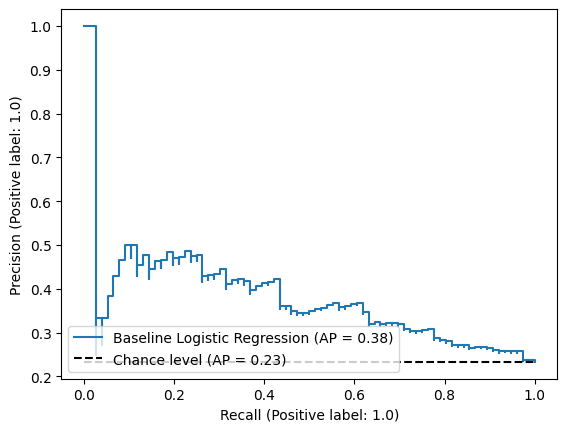

In [7]:
###########################################
# Logistic Regression Model
###########################################

class_weights= {1:1.0, 0:0.5} # set class weights for unbalanced dataset
model = LogisticRegression(random_state=42,
                           class_weight=class_weights)

# Fit the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = model.score(X_test, y_test)
precision, recall, f_score, support = precision_recall_fscore_support(
    y_test, y_pred,
    average='weighted')

print("New Child Prediction: Logistic Regression Baseline Model")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F Score: {f_score:.3f}")

metrics.PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, 
    name="Baseline Logistic Regression", 
    plot_chance_level=True)


New Child Prediction: Neural Network Baseline Model
Accuracy: 0.730
Precision: 0.647
Recall: 0.730
F Score: 0.673


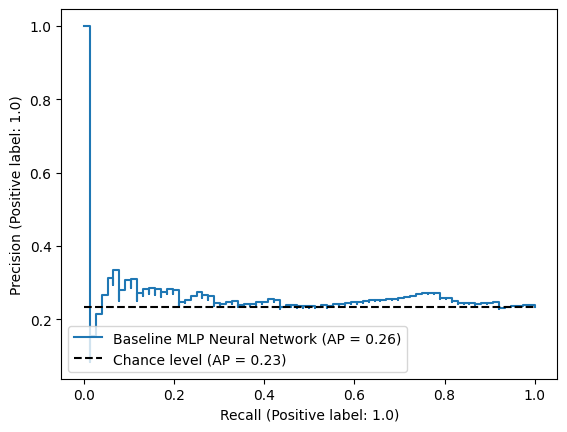

In [8]:
###########################################
# Neural Network Baseline Model
###########################################

model = MLPClassifier(hidden_layer_sizes=(50,10), random_state=42)

# Fit the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = model.score(X_test, y_test)
precision, recall, f_score, support = precision_recall_fscore_support(
    y_test, y_pred,
    average='weighted')

print("New Child Prediction: Neural Network Baseline Model")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F Score: {f_score:.3f}")

metrics.PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, 
    name="Baseline MLP Neural Network", 
    plot_chance_level=True)

New Child Prediction: Gaussian Naive Bayes Baseline Model
Accuracy: 0.785
Precision: 0.759
Recall: 0.785
F Score: 0.737


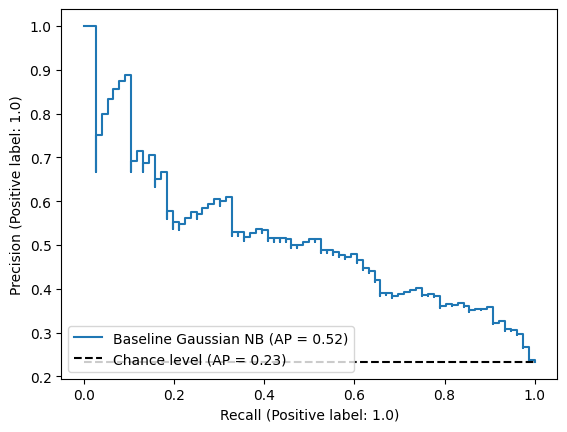

In [9]:
###########################################
# Gaussian NB Baseline Model
###########################################

model = GaussianNB()

# Fit the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = model.score(X_test, y_test)
precision, recall, f_score, support = precision_recall_fscore_support(
    y_test, y_pred,
    average='weighted')

print("New Child Prediction: Gaussian Naive Bayes Baseline Model")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F Score: {f_score:.3f}")

metrics.PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, 
    name="Baseline Gaussian NB", 
    plot_chance_level=True)

New Child Prediction: SVC Baseline Model
Accuracy: 0.752
Precision: 0.675
Recall: 0.752
F Score: 0.686


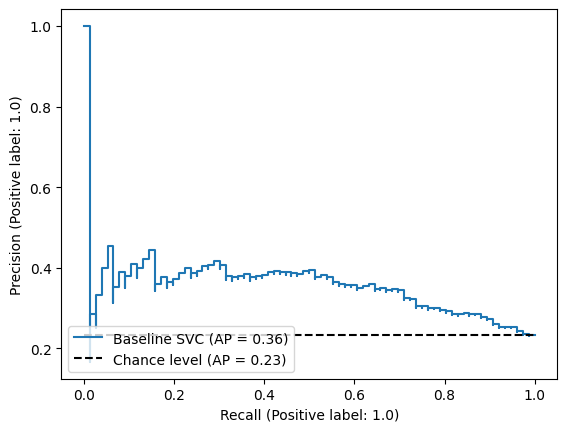

In [10]:
###########################################
# SVC Baseline Model
###########################################

model = SVC(random_state=9,
            kernel="linear", 
            class_weight=class_weights)

# Fit the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = model.score(X_test, y_test)
precision, recall, f_score, support = precision_recall_fscore_support(
    y_test, y_pred,
    average='weighted')

print("New Child Prediction: SVC Baseline Model")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F Score: {f_score:.3f}")

metrics.PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, 
    name="Baseline SVC", 
    plot_chance_level=True)

New Child Prediction: Random Forest Baseline Model
Accuracy: 0.764
Precision: 0.737
Recall: 0.764
F Score: 0.744


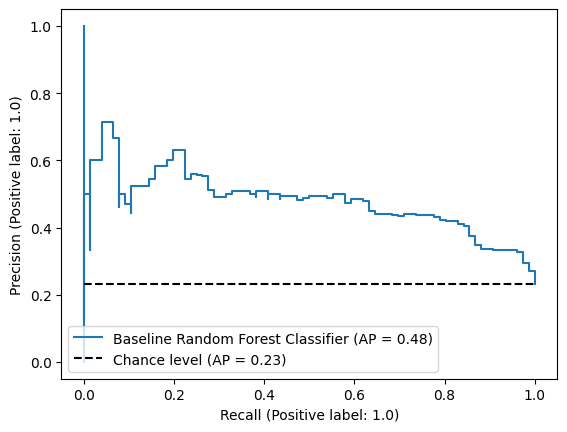

In [11]:
###########################################
# Random Forest Baseline Model
###########################################

model = RandomForestClassifier(random_state=42,
                               class_weight=class_weights)

# Fit the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = model.score(X_test, y_test)
precision, recall, f_score, support = precision_recall_fscore_support(
    y_test, y_pred,
    average='weighted')

print("New Child Prediction: Random Forest Baseline Model")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F Score: {f_score:.3f}")

metrics.PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, 
    name="Baseline Random Forest Classifier", 
    plot_chance_level=True)

New Child Prediction: k-NN Baseline Model
Accuracy: 0.727
Precision: 0.673
Recall: 0.727
F Score: 0.690


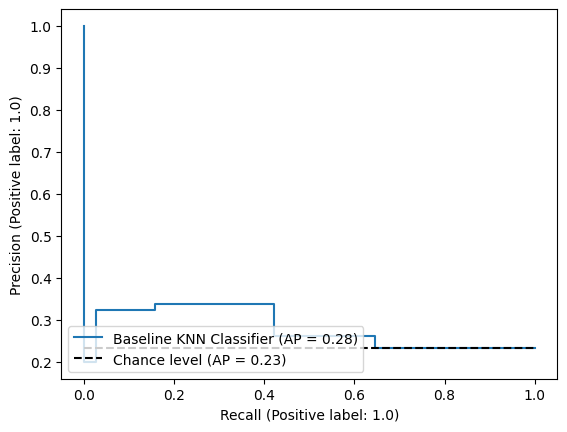

In [12]:
###########################################
# KNN Baseline Model
###########################################

model = KNeighborsClassifier()

# Fit the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = model.score(X_test, y_test)
precision, recall, f_score, support = precision_recall_fscore_support(
    y_test, y_pred,
    average='weighted')

print("New Child Prediction: k-NN Baseline Model")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F Score: {f_score:.3f}")

metrics.PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, 
    name="Baseline KNN Classifier", 
    plot_chance_level=True)

### New Child Prediction: Dummy Models

In [13]:

###########################################
# True Random Baseline Model
###########################################


model = DummyClassifier(strategy="uniform", random_state=42)

# Fit the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = model.score(X_test, y_test)
precision, recall, f_score, support = precision_recall_fscore_support(
    y_test, y_pred,
    average='weighted')

print("New Child Prediction: Dummy Model - True Random")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F Score: {f_score:.3f}")

###########################################
# Stratified Random Baseline Model
###########################################

model = DummyClassifier(strategy="stratified", random_state=42)

# Fit the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = model.score(X_test, y_test)
precision, recall, f_score, support = precision_recall_fscore_support(
    y_test, y_pred,
    average='weighted')

print("\nNew Child Prediction: Dummy Model - Stratified Random")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F Score: {f_score:.3f}")

###########################################
# Weighted Random Baseline Model
###########################################

outcomes = [0, 1]
weights = [(525/661), (136/661)] # using y_train
random.seed(42)

y_pred = [random.choices(outcomes, weights) for _ in range(len(X_test))]

y_results = 0
for i in range(len(y_test)):
    if y_test.iloc[i] == y_pred[i][0]:
        y_results += 1

accuracy = y_results/len(y_test)
precision, recall, f_score, support = precision_recall_fscore_support(
    y_test, y_pred,
    average='weighted')

print("\nNew Child Prediction: Dummy Model - Weighted Random")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F Score: {f_score:.3f}")

New Child Prediction: Dummy Model - True Random
Accuracy: 0.454
Precision: 0.598
Recall: 0.454
F Score: 0.496

New Child Prediction: Dummy Model - Stratified Random
Accuracy: 0.647
Precision: 0.639
Recall: 0.647
F Score: 0.643

New Child Prediction: Dummy Model - Weighted Random
Accuracy: 0.607
Precision: 0.607
Recall: 0.607
F Score: 0.607


### PreFer Submitted Model

This is the model submitted to PreFer. Re-running it here to get accuracy metrics.

In [14]:
# get list of var_names
var_names = [
    "nomem_encr",  # ID variable required for predictions,
    "birthyear_bg",
    "age_bg",
    "cf20m130", # Within how many years do you hope to have your first/next child?
    "cf20m128", # Do you think you will have children in the future?
    "cf20m129", # How many children do you think you'll have?
    "cf20m031", # What year did you marry?
]

# take mean of income and median education across waves (grouped by unique IDs)
df = main_data[var_names]

# now we have just df of those who have outcome data
subset_df = df[df['nomem_encr'].isin(have_outcome_child)]
subset_df = subset_df.fillna(0)
# get outcome data
outcome_data = pd.read_csv('training_data/PreFer_train_outcome.csv')
# set X, y for the model training function
model_df = pd.merge(subset_df, outcome_data[outcome_data['nomem_encr'].isin(have_outcome_child)], on="nomem_encr")
X = model_df.drop(['new_child', 'nomem_encr'], axis=1)
y = model_df['new_child']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=111)

# fit logistic regression model
model_baseline_lr = LogisticRegression()
model_baseline_lr.fit(X_train, y_train)

y_pred = model_baseline_lr.predict(X_test)

accuracy = model.score(X_test, y_test)
precision, recall, f_score, support = precision_recall_fscore_support(
    y_test, y_pred,
    average='weighted')

print("New Child Prediction: Model Submitted to PreFer")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F Score: {f_score:.3f}")



New Child Prediction: Model Submitted to PreFer
Precision: 0.802
Recall: 0.813
F Score: 0.781


### Model Comparison Plot

/var/folders/99/w8jtz3l97r9f018pcnl678l80000gp/T/ipykernel_69486/2084498413.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


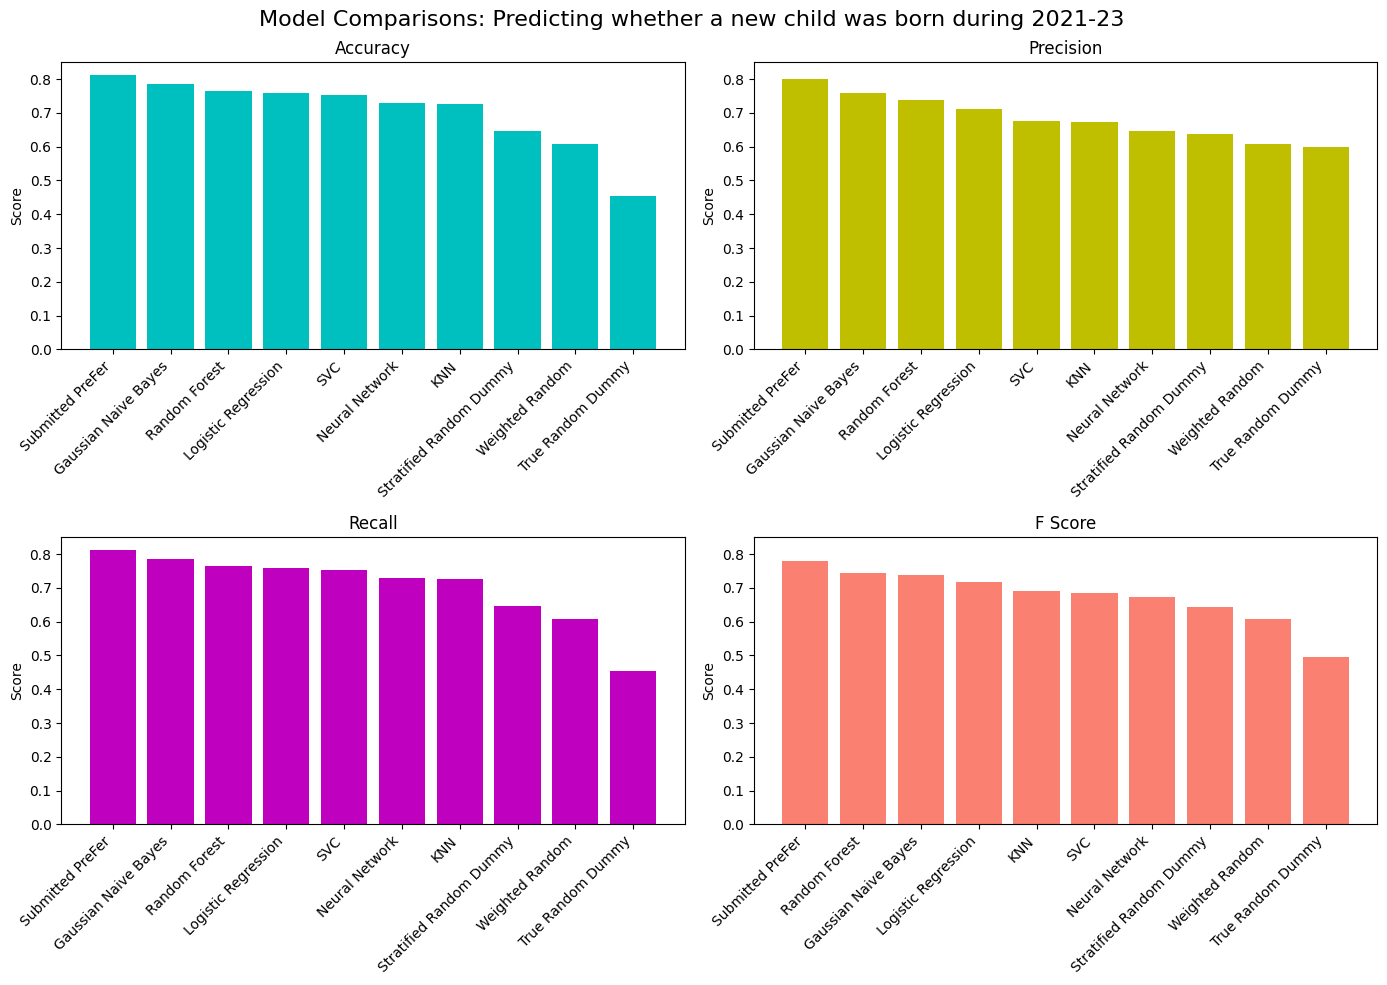

In [15]:
###########################################
# MODEL COMPARISON PLOT
###########################################

models = ['KNN',
          'Random Forest',
          'SVC' ,
          'Gaussian Naive Bayes', 
          'Neural Network', 
          'Logistic Regression', 
          'True Random Dummy',
          'Stratified Random Dummy',
          'Weighted Random',
          'Submitted PreFer']

accuracy = [0.727, 0.764, 0.752, 0.785, 0.73, 0.758, 0.454, 0.647, 0.607, 0.813]
precision = [0.673, 0.737, 0.675, 0.759, 0.647, 0.713, 0.598, 0.639, 0.607, 0.802]
recall = [0.727, 0.764, 0.752, 0.785, 0.73, 0.758, 0.454, 0.647, 0.607, 0.813]
f_score = [0.69, 0.744, 0.686, 0.737, 0.673, 0.719, 0.496, 0.643, 0.607, 0.781]


# Sort the models by metric, descending
sorted_models_accuracy = [x for _, x in sorted(zip(accuracy, models), reverse=True)]
sorted_accuracy = sorted(accuracy, reverse=True)

sorted_models_precision = [x for _, x in sorted(zip(precision, models), reverse=True)]
sorted_precision = sorted(precision, reverse=True)

sorted_models_recall = [x for _, x in sorted(zip(recall, models), reverse=True)]
sorted_recall = sorted(recall, reverse=True)

sorted_models_f_score = [x for _, x in sorted(zip(f_score, models), reverse=True)]
sorted_f_score = sorted(f_score, reverse=True)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# title
fig.suptitle('Model Comparisons: Predicting whether a new child was born during 2021-23', fontsize=16)

# plot accuracy
axs[0, 0].bar(sorted_models_accuracy, sorted_accuracy, color='c')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_ylabel('Score')
axs[0, 0].set_ylim([0, 0.85])  # Set y-axis limits

# plot precision
axs[0, 1].bar(sorted_models_precision, sorted_precision, color='y')
axs[0, 1].set_title('Precision')
axs[0, 1].set_ylabel('Score')
axs[0, 1].set_ylim([0, 0.85])

# plot recall
axs[1, 0].bar(sorted_models_recall, sorted_recall, color='m')
axs[1, 0].set_title('Recall')
axs[1, 0].set_ylabel('Score')
axs[1, 0].set_ylim([0, 0.85])

# plot f score
axs[1, 1].bar(sorted_models_f_score, sorted_f_score, color='salmon')
axs[1, 1].set_title('F Score')
axs[1, 1].set_ylabel('Score')
axs[1, 1].set_ylim([0, 0.85])

# rotate x-axis labels for better readability
for ax in axs.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('model_comparison_ranked.png')
plt.show()


<br>

***

## Prediction Task 2: Subject Health Ratings

In [16]:
# get outcome data for subjective health ratings (we use main dataset to grab this variable)
outcome_data_health = main_data[['nomem_encr', 'ch20m004']]

# set X, y for the model training function
model_df = pd.merge(health_df, outcome_data_health[outcome_data_health['nomem_encr'].isin(have_outcome_health)], on="nomem_encr")

X = model_df.drop(['ch20m004', 'nomem_encr'], axis=1)
y = model_df['ch20m004']

# split test/train into 33/77
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=111)

### Health Rating: Baseline Models

In [17]:
###########################################
# Logistic Regression Baseline Model
###########################################
class_weights= {1:0.1, 
                2:0.5,
                3:1.0,
                4:1.0,
                5:0.1} # set class weights for unbalanced dataset
model_baseline_lr = LogisticRegression(random_state=42, class_weight=class_weights, max_iter=1000) # defaults to one-v-rest

# Fit the model
model_baseline_lr.fit(X_train, y_train)

y_pred = model_baseline_lr.predict(X_test)

accuracy = model_baseline_lr.score(X_test, y_test)
precision, recall, f_score, support = precision_recall_fscore_support(
    y_test, y_pred,
    average='weighted',
    zero_division=0)

print("Health Ratings: One-v-Rest Logistic Regression")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F Score: {f_score:.3f}")


Health Ratings: One-v-Rest Logistic Regression
Accuracy: 0.508
Precision: 0.407
Recall: 0.508
F Score: 0.380


In [18]:
###########################################
# Neural Network Baseline Model
###########################################

model_baseline_mlp = MLPClassifier(random_state=42, hidden_layer_sizes=(50,20))

# Fit the model
model_baseline_mlp.fit(X_train, y_train)

y_pred = model_baseline_mlp.predict(X_test)

accuracy = model_baseline_mlp.score(X_test, y_test)
precision, recall, f_score, support = precision_recall_fscore_support(
    y_test, y_pred,
    average='weighted',
    zero_division=0)

print("Health Ratings: Neural Network")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F Score: {f_score:.3f}")

Health Ratings: Neural Network
Accuracy: 0.315
Precision: 0.249
Recall: 0.315
F Score: 0.271


In [19]:
###########################################
# Gaussian NB Baseline Model
###########################################

model_baseline_gnb = GaussianNB()

# Fit the model
model_baseline_gnb.fit(X_train, y_train)

y_pred = model_baseline_gnb.predict(X_test)

accuracy = model_baseline_gnb.score(X_test, y_test)
precision, recall, f_score, support = precision_recall_fscore_support(
    y_test, y_pred,
    average='weighted',
    zero_division=0)

print("Health Ratings: Gaussian NB")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F Score: {f_score:.3f}")

Health Ratings: Gaussian NB
Accuracy: 0.500
Precision: 0.412
Recall: 0.500
F Score: 0.435


In [20]:
###########################################
# SVC Baseline Model
###########################################

model_baseline_svc = SVC(random_state=42, class_weight=class_weights)

# Fit the model
model_baseline_svc.fit(X_train, y_train)

y_pred = model_baseline_svc.predict(X_test)

accuracy = model_baseline_svc.score(X_test, y_test)
precision, recall, f_score, support = precision_recall_fscore_support(
    y_test, y_pred,
    average='weighted',
    zero_division=0)

print("Health Ratings: SVC")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F Score: {f_score:.3f}")

Health Ratings: SVC
Accuracy: 0.504
Precision: 0.254
Recall: 0.504
F Score: 0.338


In [21]:
###########################################
# Random Forest Baseline Model
###########################################

model_baseline_rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Fit the model
model_baseline_rf.fit(X_train, y_train)

y_pred = model_baseline_rf.predict(X_test)

accuracy = model_baseline_rf.score(X_test, y_test)
precision, recall, f_score, support = precision_recall_fscore_support(
    y_test, y_pred,
    average='weighted',
    zero_division=0)

print("Health Ratings: Random Forest")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F Score: {f_score:.3f}")

Health Ratings: Random Forest
Accuracy: 0.419
Precision: 0.384
Recall: 0.419
F Score: 0.400


In [22]:
###########################################
# KNN Baseline Model
###########################################

model_baseline_knn = KNeighborsClassifier()

# Fit the model
model_baseline_knn.fit(X_train, y_train)

y_pred = model_baseline_knn.predict(X_test)

accuracy = model_baseline_knn.score(X_test, y_test)
precision, recall, f_score, support = precision_recall_fscore_support(
    y_test, y_pred,
    average='weighted')

print("Health Ratings: k-Nearest Neighbour")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F Score: {f_score:.3f}")

Health Ratings: k-Nearest Neighbour
Accuracy: 0.415
Precision: 0.379
Recall: 0.415
F Score: 0.392


### Health Ratings: Dummy Models

In [23]:
###########################################
# True Random Baseline Model
###########################################

model_baseline_true_random = DummyClassifier(strategy="uniform", random_state=42)

# Fit the model
model_baseline_true_random.fit(X_train, y_train)

y_pred = model_baseline_true_random.predict(X_test)

accuracy = model_baseline_true_random.score(X_test, y_test)
precision, recall, f_score, support = precision_recall_fscore_support(
    y_test, y_pred,
    average='weighted')

print("Health Ratings: True Random")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F Score: {f_score:.3f}")

###########################################
# Stratified Random Baseline Model
###########################################

model_baseline_strat_random = DummyClassifier(strategy="stratified", random_state=42)

# Fit the model
model_baseline_strat_random.fit(X_train, y_train)

y_pred = model_baseline_strat_random.predict(X_test)

accuracy = model_baseline_strat_random.score(X_test, y_test)
precision, recall, f_score, support = precision_recall_fscore_support(
    y_test, y_pred,
    average='weighted')

print("\nHealth Ratings: Stratified Random")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F Score: {f_score:.3f}")

###########################################
# Weighted Random Baseline Model
###########################################

outcomes = [1, 2, 3, 4, 5]
weights = [14, 101, 490, 362, 88]

random.seed(42)

y_pred = [random.choices(outcomes, weights) for _ in range(len(X_test))]

y_results = 0
for i in range(len(y_test)):
    if y_test.iloc[i] == y_pred[i][0]:
        y_results += 1

accuracy = y_results/len(y_test)
precision, recall, f_score, support = precision_recall_fscore_support(
    y_test, y_pred,
    average='weighted')

print("\nHealth Ratings: Weighted Random")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F Score: {f_score:.3f}")


Health Ratings: True Random
Accuracy: 0.181
Precision: 0.342
Recall: 0.181
F Score: 0.220

Health Ratings: Stratified Random
Accuracy: 0.373
Precision: 0.383
Recall: 0.373
F Score: 0.377

Health Ratings: Weighted Random
Accuracy: 0.360
Precision: 0.372
Recall: 0.360
F Score: 0.365


### Model Comparison: Plot

/var/folders/99/w8jtz3l97r9f018pcnl678l80000gp/T/ipykernel_69486/3874193410.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


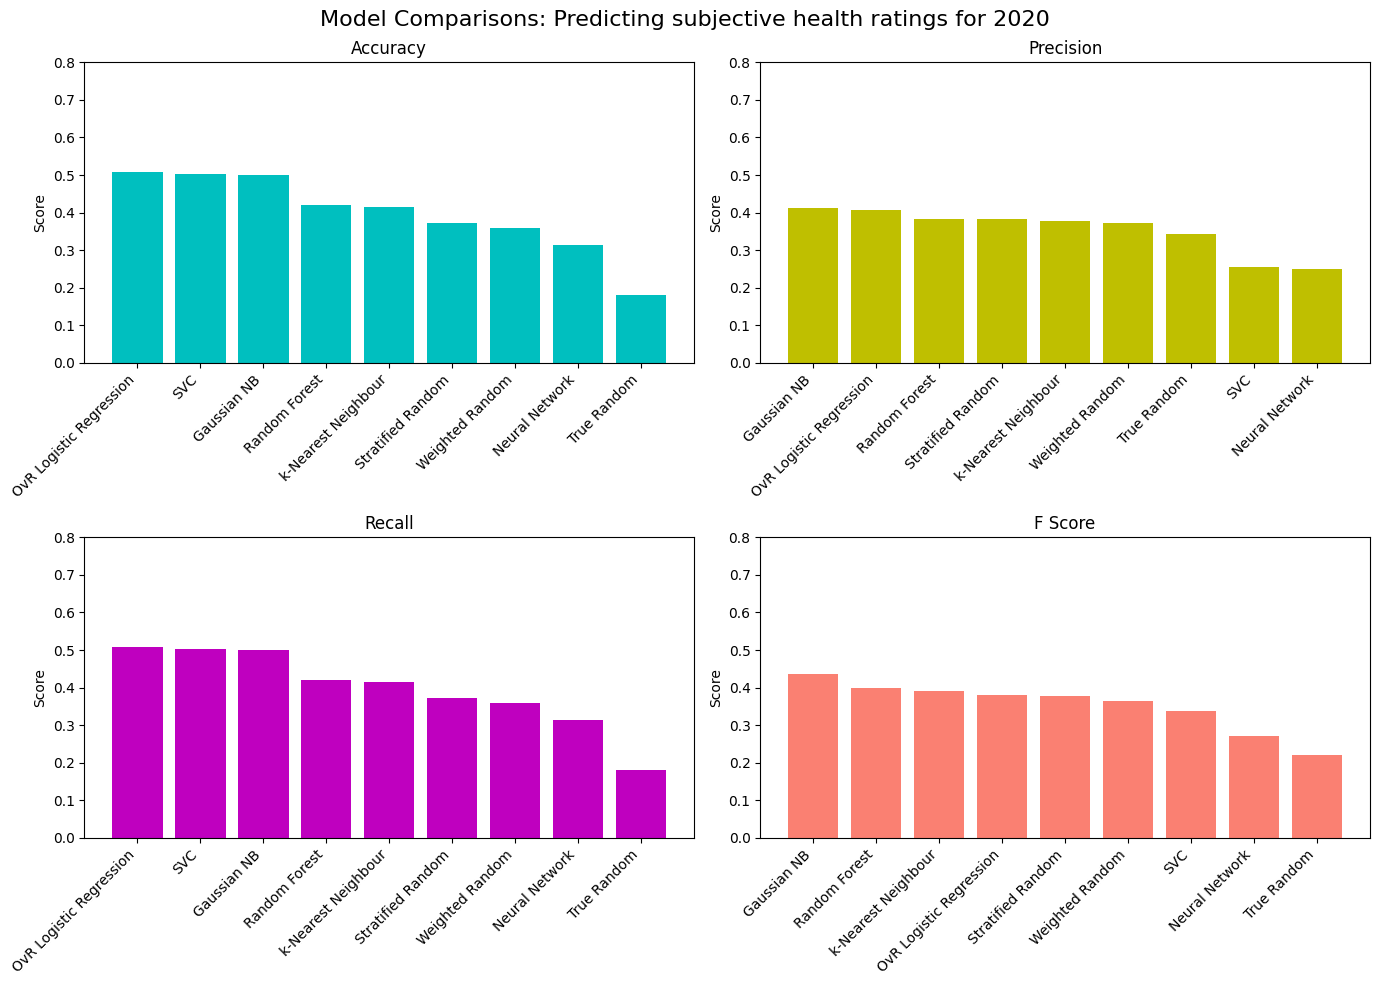

In [24]:
###########################################
# MODEL COMPARISON PLOT
###########################################

models = ['True Random', 'Stratified Random', 'Weighted Random', 'k-Nearest Neighbour', 
          'Random Forest', 'SVC', 'Gaussian NB', 'Neural Network', 'OvR Logistic Regression']


accuracy = [0.181, 0.373, 0.360, 0.415, 0.419, 0.504, 0.500, 0.315, 0.508]
precision = [0.342, 0.383, 0.372, 0.379, 0.384, 0.254, 0.412, 0.249, 0.407]
recall = [0.181, 0.373, 0.360, 0.415, 0.419, 0.504, 0.500, 0.315, 0.508]
f_score = [0.220, 0.377, 0.365, 0.392, 0.400, 0.338, 0.435, 0.271, 0.380]


# Sort the models by metric, descending
sorted_models_accuracy = [x for _, x in sorted(zip(accuracy, models), reverse=True)]
sorted_accuracy = sorted(accuracy, reverse=True)

sorted_models_precision = [x for _, x in sorted(zip(precision, models), reverse=True)]
sorted_precision = sorted(precision, reverse=True)

sorted_models_recall = [x for _, x in sorted(zip(recall, models), reverse=True)]
sorted_recall = sorted(recall, reverse=True)

sorted_models_f_score = [x for _, x in sorted(zip(f_score, models), reverse=True)]
sorted_f_score = sorted(f_score, reverse=True)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# title
fig.suptitle('Model Comparisons: Predicting subjective health ratings for 2020', fontsize=16)

# plot accuracy
axs[0, 0].bar(sorted_models_accuracy, sorted_accuracy, color='c')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_ylabel('Score')
axs[0, 0].set_ylim([0, 0.8])  # Set y-axis limits

# plot precision
axs[0, 1].bar(sorted_models_precision, sorted_precision, color='y')
axs[0, 1].set_title('Precision')
axs[0, 1].set_ylabel('Score')
axs[0, 1].set_ylim([0, 0.8])

# plot recall
axs[1, 0].bar(sorted_models_recall, sorted_recall, color='m')
axs[1, 0].set_title('Recall')
axs[1, 0].set_ylabel('Score')
axs[1, 0].set_ylim([0, 0.8])

# plot f score
axs[1, 1].bar(sorted_models_f_score, sorted_f_score, color='salmon')
axs[1, 1].set_title('F Score')
axs[1, 1].set_ylabel('Score')
axs[1, 1].set_ylim([0, 0.8])

# rotate x-axis labels for better readability
for ax in axs.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('model_comparison_ranked_health.png')
plt.show()